In [127]:
%load_ext autoreload
%autoreload 2
import polars as pl
from scipy.stats import binned_statistic_2d
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeaature
from src.loading import *
from src.saving import *
from src.plotting import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
# Load global PF stats
# (Takes about 7 sec)
pf_stats = load_global_merged_pf_stats()

In [124]:
# Bin lat and lon into dx x dx grids
#
dx = 2
lat_grids = np.arange(-90, 90+dx, dx)
lon_grids = np.arange(-180, 180+dx, dx)
OBS_THRESH = 10
def _grid_mean_stat(data_to_bin=None, statistic='count'):
    stat = binned_statistic_2d(
        pf_stats['mean_latitude'],
        pf_stats['mean_longitude'], 
        values = data_to_bin,
        statistic = statistic,
        bins=[lat_grids, lon_grids]
    ).statistic
    return stat

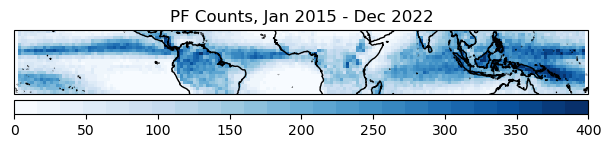

In [133]:
# Counts of PFs
#
pf_count = _grid_mean_stat()
fig, ax = plt.subplots(figsize=(6,6), constrained_layout=True, subplot_kw={'projection': ccrs.PlateCarree()})
c = ax.pcolormesh(
    lon_grids, 
    lat_grids,
    pf_count,
    cmap=discrete_cmap('Blues', 25),
    norm=colors.Normalize(vmin=0, vmax=400),
    transform=ccrs.PlateCarree()
)
cb = fig.colorbar(c, orientation='horizontal', shrink=1, aspect=40, pad=0.01)
ax.set_ylim(-20, 20)
ax.coastlines(color='black')
ax.set_title('PF Counts, Jan 2015 - Dec 2022')
save_figure(fig, 'Tropical PF Counts.pdf')

/var/folders/1t/6drgwyc17q12xmq4h7m454vw0000gn/T/ipykernel_89317/2568487623.py:6: RuntimeWarning: invalid value encountered in divide
  ex_pf_frac = 100*ex_pf_count/pf_count


Text(0.5, 1.0, 'ExPF Percentage of PFs, Jan 2015 - Dec 2022')

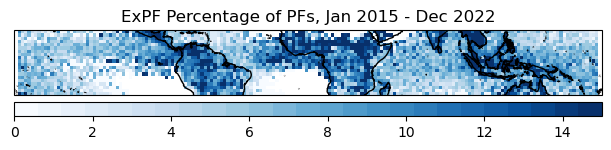

In [135]:
# Fraction of PFs over a given region that are extreme
#
extreme_pf_mask = pf_stats['max_precip'] >= 60
ex_pf_count = _grid_mean_stat(extreme_pf_mask, 'sum')
pf_count = _grid_mean_stat()
ex_pf_frac = 100*ex_pf_count/pf_count
ex_pf_frac[pf_count<OBS_THRESH] = np.nan
fig, ax = plt.subplots(figsize=(6,6), constrained_layout=True, subplot_kw={'projection': ccrs.PlateCarree()})
c = ax.pcolormesh(
    lon_grids, 
    lat_grids,
    ex_pf_frac,
    cmap=discrete_cmap('Blues', 25),
    norm=colors.Normalize(vmin=0, vmax=15),
    transform=ccrs.PlateCarree()
)
cb = fig.colorbar(c, orientation='horizontal', shrink=1, aspect=40, pad=0.01)
ax.set_ylim(-20, 20)
ax.coastlines(color='black')
ax.set_title('ExPF Percentage of PFs, Jan 2015 - Dec 2022')

In [144]:
area.min()

25.0

/var/folders/1t/6drgwyc17q12xmq4h7m454vw0000gn/T/ipykernel_89317/2538438936.py:10: RuntimeWarning: Mean of empty slice
  statistic = lambda x: np.nanmean(x) if x.size > OBS_THRESH else np.nan


Text(0.5, 1.0, 'Non-ExPF Mean Localization')

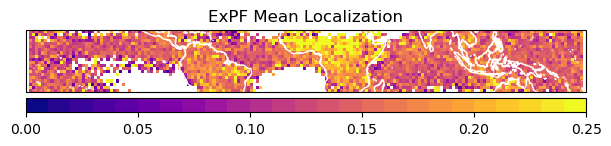

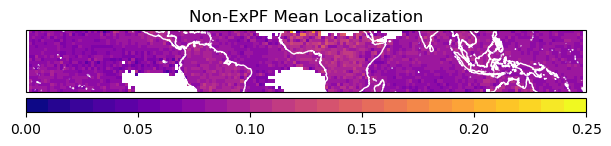

In [ ]:
# Localization indices of the PFs
#
area = pf_stats['largest_10mmhr_cluster_size_pixels'] / pf_stats['num_pixels']

# Separate areas of extremes and non-extremes
#
expf_loc = loc.set(~(pf_stats["max_precip"] >= 60), np.nan)     # Nan out where max precip is too low
non_expf_loc = loc.set(~(pf_stats["max_precip"] <= 20), np.nan) # Nan out where max precip is too high

statistic = lambda x: np.nanmean(x) if x.size > OBS_THRESH else np.nan
expf_mean_loc = _grid_mean_stat(expf_loc, statistic)
non_expf_mean_loc = _grid_mean_stat(non_expf_loc, statistic)

# Extreme PFs
#
fig, ax = plt.subplots(figsize=(6,6), constrained_layout=True, subplot_kw={'projection': ccrs.PlateCarree()})
c = ax.pcolormesh(
    lon_grids, 
    lat_grids,
    expf_mean_loc,
    cmap=discrete_cmap('plasma', 25),
    norm=colors.Normalize(vmin=0, vmax=0.25),
    transform=ccrs.PlateCarree()
)
cb = fig.colorbar(c, orientation='horizontal', shrink=1, aspect=40, pad=0.01)
ax.set_ylim(-20, 20)
ax.coastlines(color='white')
ax.set_title('ExPF Mean Localization')

# Non-Extreme PFs
fig, ax = plt.subplots(figsize=(6,6), constrained_layout=True, subplot_kw={'projection': ccrs.PlateCarree()})
c = ax.pcolormesh(
    lon_grids, 
    lat_grids,
    non_expf_mean_loc,
    cmap=discrete_cmap('plasma', 25),
    norm=colors.Normalize(vmin=0, vmax=0.25),
    transform=ccrs.PlateCarree()
)
cb = fig.colorbar(c, orientation='horizontal', shrink=1, aspect=40, pad=0.01)
ax.set_ylim(-20, 20)
ax.coastlines(color='white')
ax.set_title('Non-ExPF Mean Localization')

/var/folders/1t/6drgwyc17q12xmq4h7m454vw0000gn/T/ipykernel_89317/1536750576.py:9: RuntimeWarning: Mean of empty slice
  statistic = lambda x: np.nanmean(x) if x.size > OBS_THRESH else np.nan


Text(0.5, 1.0, 'Non-ExPF Mean Principal Core Size')

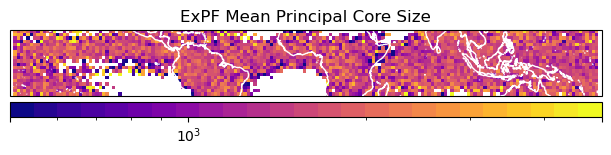

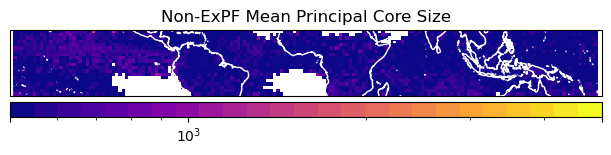

In [155]:
# Sizes of the PFs
#
area = pf_stats['num_pixels'] * 25.0
# Separate area of extremes and non-extremes
#
expf_area = area.set(~(pf_stats["max_precip"] >= 60), np.nan)     # Nan out where max precip is too low
non_expf_area = area.set(~(pf_stats["max_precip"] <= 20), np.nan) # Nan out where max precip is too high

statistic = lambda x: np.nanmean(x) if x.size > OBS_THRESH else np.nan
expf_mean_area = _grid_mean_stat(expf_area, statistic)
non_expf_mean_area = _grid_mean_stat(non_expf_area, statistic)

# Extreme PFs
#
fig, ax = plt.subplots(figsize=(6,6), constrained_layout=True, subplot_kw={'projection': ccrs.PlateCarree()})
c = ax.pcolormesh(
    lon_grids, 
    lat_grids,
    expf_mean_area,
    cmap=discrete_cmap('plasma', 25),
    norm=colors.LogNorm(vmin=500, vmax=5e3),
    transform=ccrs.PlateCarree()
)
cb = fig.colorbar(c, orientation='horizontal', shrink=1, aspect=40, pad=0.01)
cb.ax.set_xticks([500, 1000, 5_000])
ax.set_ylim(-20, 20)
ax.coastlines(color='white')
ax.set_title('ExPF Mean Principal Core Size')

# Non-Extreme PFs
fig, ax = plt.subplots(figsize=(6,6), constrained_layout=True, subplot_kw={'projection': ccrs.PlateCarree()})
c = ax.pcolormesh(
    lon_grids, 
    lat_grids,
    non_expf_mean_area,
    cmap=discrete_cmap('plasma', 25),
    norm=colors.LogNorm(vmin=500, vmax=5e3),
    transform=ccrs.PlateCarree()
)
cb = fig.colorbar(c, orientation='horizontal', shrink=1, aspect=40, pad=0.01)
cb.ax.set_xticks([500, 1000, 5_000])
ax.set_ylim(-20, 20)
ax.coastlines(color='white')
ax.set_title('Non-ExPF Mean Principal Core Size')